# Fit Rankine, Holland, Willoughby and Chavas profiles on SAR data
Note that so far the Rmax is searched in the first 200km around the TC center (in the code this impacts how the functions are initialized, but also when the curves are plot (on the smaller scale graph).

For the fitting, we constrain Rmax > 5km which works well for a lot of TCs. 

In the papers of Holland, Willoughby and Chavas, the wind used is the tangential wind (same for Rankine). 

TODO:

==> Translate Chavas by Vmin;

==> Check for total wind speed and if it works, erase the all_data.ipynb

==> Which profiles work when? etc...

==> Chavas looks worse, but this is because the other profiles use curve_fit(). Try to define the other profiles just with the input parameters.


In [8]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import griddata
from scipy.optimize import curve_fit

import glob

import functions as f

In [9]:
### PATHS
dir_path = '/home/arthur/data/cyclobs/rotated_files/'
all_data = glob.glob(dir_path + "*.nc")
print("Total number of files:", len(all_data))
# Savepath to be modified directly in the function

### PARAMS
PARAMS = {
    'r_window_len':          501,  # Scale for radius (km)
    'rmax_window':           300,  # Window in whick we look for Rmax (e.g [0, 200km])
    'chavas_vfit':           17, 
    'tangential_wind_speed': True, # If False, total wind speed is used
    'print_values':          False, 
    'save_dir':              "/home/arthur/results/windProfiles/v2/"
    }

Total number of files: 384


In [10]:
# INITIALIZE DATA STRUCTURE
INI = {           # Initial values
    'Rankine':    [], # x, alpha, Vmin, Rmax
    'Holland':    [], # Lat, pn, pc, Vmin, Rmax, Vmax
    'Willoughby': [], # n, X1, Vmin, Rmax, Vmax
    'Chavas':     []  # Vmax, Rfit, Vfit, fcor, Cdvary, Cd, w_cool, CkCdvary, CkCd, eye_adj, alpha_eye
    } 
FIT = {           # Fit values
    'Rankine':    [], # x, alpha, Vmin, Rmax
    'Holland':    [], # Lat, pn, pc, Vmin, Rmax, Vmax
    'Willoughby': [], # n, X1, Vmin, Rmax, Vmax
    'Chavas':     []  # rr, VV, rmax, r0, rmerge, Vmerge
    } 

1 =>     /home/arthur/data/cyclobs/rotated_files/s1b-ew-owi-cm-20180902t143708-20180902t143912-000003-01720F_ll_gd_rotated.nc


/home/arthur/scripts/windProfiles/symmetric/functions.py:274: RuntimeWarning: divide by zero encountered in true_divide
  V_ER11 = (1. / rr_ER11) * (Vmax * rmax + .5 * fcor * rmax ** 2) * ((2 * (rr_ER11 / rmax) ** 2) / (2 - CkCd + CkCd * (rr_ER11 / rmax) ** 2)) ** (1 / (2 - CkCd)) - .5 * fcor * rr_ER11
/home/arthur/scripts/windProfiles/symmetric/functions.py:274: RuntimeWarning: invalid value encountered in multiply
  V_ER11 = (1. / rr_ER11) * (Vmax * rmax + .5 * fcor * rmax ** 2) * ((2 * (rr_ER11 / rmax) ** 2) / (2 - CkCd + CkCd * (rr_ER11 / rmax) ** 2)) ** (1 / (2 - CkCd)) - .5 * fcor * rr_ER11
/home/arthur/scripts/windProfiles/symmetric/functions.py:188: RuntimeWarning: invalid value encountered in true_divide
  VV = (Mm / rmax) * (MMfracMm / rrfracrm) - .5 * fcor * rmax * rrfracrm #[ms-1]


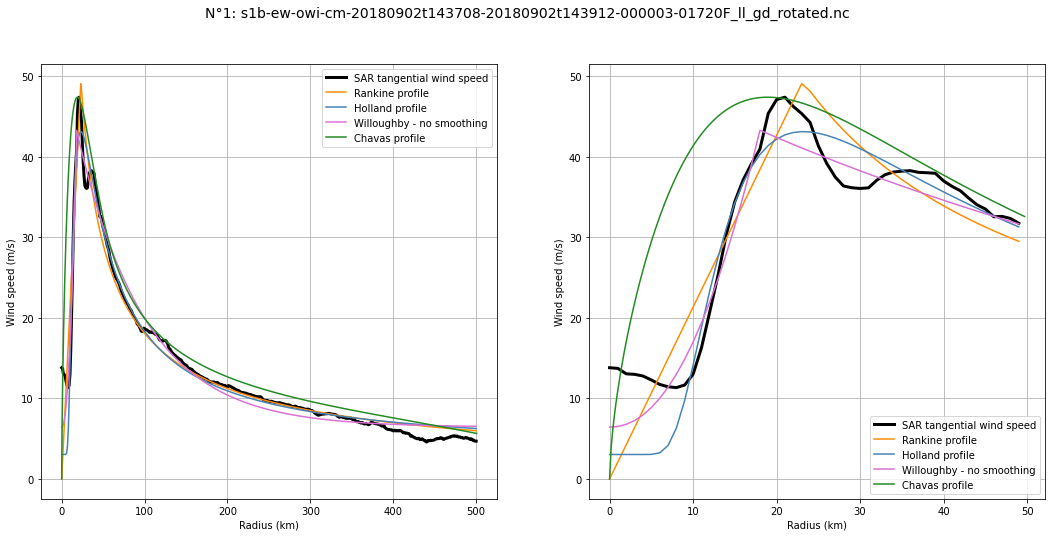

In [11]:
# FIT AND PRINT ALL THE PROFILES ON ALL THE DATA
i   = 0
for file in all_data[:1]:
    i += 1
    print(i, "=>    ", file)
    # Open file and compute mean wind speed
    ds      = xr.open_dataset(file)
    if PARAMS['tangential_wind_speed']:
        spdm = f.compute_mean_tangential_wind_spd(ds, r_window_len=PARAMS['r_window_len']) # TANGENTIAL WIND SPEED
    else:
        spdm = f.compute_mean_wind_spd(ds, r_window_len=PARAMS['r_window_len'])         # TOTAL WIND SPEED
    
    # Debug
    if 1 == 0: # DEBUG
        f.print_ds(ds)
        f.print_spd(ds)
        print(spdm)
    
    # Initialize and fit profile
    r, spdm, first_valid_index = f.initialize_radius(spdm)
    
    INI['Rankine']    = f.initialize_rankine(spdm, x=0.5, alpha=1.,                                PARAMS=PARAMS)
    INI['Holland']    = f.initialize_holland(spdm, Lat=np.float64(ds['lat_ref']), pn=1005, pc=950, PARAMS=PARAMS)
    INI['Willoughby'] = f.initialize_willoughby(spdm, n=1.,                                        PARAMS=PARAMS)
    INI['Chavas']     = f.initialize_chavas(spdm, Lat=np.float64(ds['lat_ref']),                   PARAMS=PARAMS)
    
    FIT['Rankine']    = f.fit_rankine(r, spdm, *INI['Rankine'],                 PARAMS=PARAMS)
    FIT['Holland']    = f.fit_holland(r, spdm, *INI['Holland'],                 PARAMS=PARAMS)
    FIT['Willoughby'] = f.fit_willoughby_no_smooth(r, spdm, *INI['Willoughby'], PARAMS=PARAMS)
    FIT['Chavas']     = f.fit_chavas(*INI['Chavas'],                            PARAMS=PARAMS)
    
    f.plot_curves(i, file, r, spdm, FIT, PARAMS)    # To only plot the curves
    # f.save_curves(i, file, ds, r, spdm, INI, FIT, PARAMS) # To save the .jpg and associated .txt files

In [12]:
a = [np.nan, np.nan, 1, 1, 1, 2, np.nan, 1, 1]

first_valid_index = np.min(np.where(np.isfinite(a)))
print(first_valid_index)

last_valid_index = np.min(np.where(np.isnan(a[first_valid_index:]))[0])
print(last_valid_index)

2
4


In [13]:
b = np.arange(0, 5)
print(b)
b[0:5]

[0 1 2 3 4]


array([0, 1, 2, 3, 4])